# DS 5001 Week 6 Lab: Similarity and Distance Measures

## Set Up

### Config

We define two OHCO lists, one to match the reduced TFIDF table we are importing, and the other to define the table after we compress this table to make clustering easier.

In [1]:
data_in = './data_in/'
data_out = './data_out/'
data_prefix = 'austen-melville'

In [2]:
OHCO_src = ['book_id', 'chap_num']
OHCO = ['book_id']

### Import

In [3]:
import pandas as pd
import numpy as np
import re 
from numpy.linalg import norm
from scipy.spatial.distance import pdist

In [4]:
import seaborn as sns
sns.set(style="ticks")

## Prepare the Data

### Import tables

In [5]:
TFIDF = pd.read_csv('{}/{}-TFIDF_REDUCED.csv'.format(data_in, data_prefix)).set_index(OHCO_src)
VOCAB = pd.read_csv('{}/{}-VOCAB2.csv'.format(data_in, data_prefix)).set_index('term_id')
LIB = pd.read_csv('{}/{}-LIB2.csv'.format(data_in, data_prefix)).set_index('book_id')

In [6]:
TFIDF.head()

24746  5094     22335     20056      7714     29409  \
book_id chap_num                                                        
105     1           0.0   0.0  0.000270  0.000000  0.000000  0.000000   
        2           0.0   0.0  0.000000  0.000000  0.000000  0.000000   
        3           0.0   0.0  0.000000  0.000000  0.000324  0.000292   
        4           0.0   0.0  0.000392  0.000000  0.000000  0.000000   
        5           0.0   0.0  0.000213  0.000212  0.000000  0.000249   

                      6294  20533     27425      2389  ...  5332  15435  \
book_id chap_num                                       ...                
105     1         0.000000    0.0  0.000000  0.000000  ...   0.0    0.0   
        2         0.000386    0.0  0.000355  0.000450  ...   0.0    0.0   
        3         0.000000    0.0  0.000000  0.000000  ...   0.0    0.0   
        4         0.000000    0.0  0.000000  0.000000  ...   0.0    0.0   
        5         0.000000    0.0  0.000000  0.000267  ...   0.0    0.0   

                  17822  29386  30142  4573  36672  39481  31545  23508  
book_id chap_num                                                         
105     1           0.0    0.0    0.0   0.0    0.0    0.0    0.0    0.0  
        2           0.0    0.0    0.0   0.0    0.0    0.0    0.0    0.0  
        3           0.0    0.0    0.0   0.0    0.0    0.0    0.0    0.0  
        4           0.0    0.0    0.0   0.0    0.0    0.0    0.0    0.0  
        5           0.0    0.0    0.0   0.0    0.0    0.0    0.0    0.0  

[5 rows x 3943 columns]

### Add Some Labels to the Library

In [7]:
LIB.loc[LIB.book_title.str.contains('Austen'), 'author'] = 'austen'
LIB.loc[LIB.book_title.str.contains('Melville'), 'author'] = 'melville'
LIB['author'] = LIB['author'].fillna('melville')
LIB['title'] = LIB.book_title.str.split(', by').apply(lambda x: x[0])

In [8]:
LIB

,book_title,book_file,author,title
book_id,,,,
158,"Emma, by Jane Austen",./data_in/epubs/AUSTEN_JANE_EMMA-pg158.txt,austen,Emma
946,"Lady Susan, by Jane Austen",./data_in/epubs/AUSTEN_JANE_LADY_SUSAN-pg946.txt,austen,Lady Susan
1212,"Love And Freindship And Other Early Works, by ...",./data_in/epubs/AUSTEN_JANE_LOVE_AND_FREINDSHI...,austen,Love And Freindship And Other Early Works
141,"Mansfield Park, by Jane Austen",./data_in/epubs/AUSTEN_JANE_MANSFIELD_PARK-pg1...,austen,Mansfield Park
121,"Northanger Abbey, by Jane Austen",./data_in/epubs/AUSTEN_JANE_NORTHANGER_ABBEY-p...,austen,Northanger Abbey
105,"Persuasion, by Jane Austen",./data_in/epubs/AUSTEN_JANE_PERSUASION-pg105.txt,austen,Persuasion
1342,"Pride and Prejudice, by Jane Austen",./data_in/epubs/AUSTEN_JANE_PRIDE_AND_PREJUDIC...,austen,Pride and Prejudice
161,"Sense and Sensibility, by Jane Austen",./data_in/epubs/AUSTEN_JANE_SENSE_AND_SENSIBIL...,austen,Sense and Sensibility
15422,"Israel Potter, by Herman Melville",./data_in/epubs/MELVILLE_HERMAN_ISRAEL_POTTER_...,melville,Israel Potter


### Collapse TFIDF

We want to work with larger bags in this notebook, in order to better visualize our resulting clusters.

In [9]:
TFIDF = TFIDF.groupby(OHCO).mean()

In [10]:
TFIDF.head()

,24746,5094,22335,20056,7714,29409,6294,20533,27425,2389,...,5332,15435,17822,29386,30142,4573,36672,39481,31545,23508
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.000068,0.000119,0.000092,0.000119,0.000116,0.000111,0.000174,0.000085,0.000030,0.000073,...,0.000064,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000024,0.0,0.0
121,0.000090,0.000049,0.000057,0.000079,0.000020,0.000100,0.000133,0.000061,0.000000,0.000145,...,0.000000,0.0,0.000017,0.000033,0.000000,0.0,0.000023,0.000037,0.0,0.0
141,0.000070,0.000046,0.000066,0.000090,0.000095,0.000122,0.000082,0.000143,0.000035,0.000102,...,0.000069,0.0,0.000014,0.000020,0.000009,0.0,0.000000,0.000032,0.0,0.0
158,0.000092,0.000092,0.000136,0.000110,0.000045,0.000060,0.000159,0.000038,0.000048,0.000059,...,0.000041,0.0,0.000000,0.000050,0.000000,0.0,0.000000,0.000048,0.0,0.0
161,0.000133,0.000087,0.000145,0.000117,0.000097,0.000093,0.000128,0.000113,0.000018,0.000142,...,0.000105,0.0,0.000025,0.000060,0.000000,0.0,0.000019,0.000054,0.0,0.0


### Create a DOC table

We want to create a new table that maps the OHCO levels to a single doc_id. We do this so that when we create a table to store pairs of docs and their distances, we can use a single-valued ID for each docs. 

This table will also be used to store cluster assignments.

All of this will become clearer below!

In [11]:
DOC = TFIDF.reset_index()[OHCO] # We create a table from the OHCO in our TFIDF table

In [12]:
DOC.head()

,book_id
0,105
1,121
2,141
3,158
4,161


In [13]:
DOC.index.name = 'doc_id' # We give the new index a name

In [14]:
DOC.head()

,book_id
doc_id,
0,105
1,121
2,141
3,158
4,161


### Add a meaningful Title to DOC index

In [15]:
DOC['title'] = DOC.book_id.map(LIB.author) \
    + '-' + DOC[OHCO].apply(lambda x: x.astype('str').str.cat(sep='-'), 1) \
    + ': '+ DOC.book_id.map(LIB.title) 

In [16]:
DOC.head()

,book_id,title
doc_id,,
0,105,austen-105: Persuasion
1,121,austen-121: Northanger Abbey
2,141,austen-141: Mansfield Park
3,158,austen-158: Emma
4,161,austen-161: Sense and Sensibility


### Create Normalized Tables

In [17]:
L0 = TFIDF.astype('bool').astype('int')
L1 = TFIDF.apply(lambda x: x / x.sum(), 1)
L2 = TFIDF.apply(lambda x: x / norm(x), 1)

In [18]:
# ((L2.T)**2).sum()

### Create Doc Pair Table

Create a table to store our results.

Note that `pist()` is a "distance matrix computation from a collection of raw observation vectors stored in a rectangular array".

In [19]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [20]:
PAIRS.shape

(190, 0)

In [21]:
PAIRS.head()

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

## Compute Distances

In [22]:
%time PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')

CPU times: user 3.16 ms, sys: 1.56 ms, total: 4.72 ms
Wall time: 2.58 ms


In [23]:
%time PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')

CPU times: user 2.67 ms, sys: 1.42 ms, total: 4.09 ms
Wall time: 2.27 ms


In [24]:
%time PAIRS['cosine'] = pdist(TFIDF, 'cosine')

CPU times: user 4.27 ms, sys: 2.04 ms, total: 6.31 ms
Wall time: 3.03 ms


In [25]:
%time PAIRS['jaccard'] = pdist(L0, 'jaccard')

CPU times: user 3.16 ms, sys: 1.97 ms, total: 5.14 ms
Wall time: 2.58 ms


In [26]:
%time PAIRS['dice'] = pdist(L0, 'dice')

CPU times: user 3.12 ms, sys: 1.57 ms, total: 4.68 ms
Wall time: 2.66 ms


In [27]:
%time PAIRS['js'] = pdist(L1, 'jensenshannon')                               

CPU times: user 24.7 ms, sys: 1.85 ms, total: 26.5 ms
Wall time: 25.3 ms


In [28]:
%time PAIRS['euclidean2'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

CPU times: user 3.39 ms, sys: 1.97 ms, total: 5.36 ms
Wall time: 2.77 ms


In [29]:
PAIRS.head()

cityblock  euclidean    cosine   jaccard      dice        js  \
doc_a doc_b                                                                 
0     1       0.149585   0.003642  0.207490  0.254389  0.145730  0.332489   
      2       0.118955   0.002980  0.145245  0.209635  0.117091  0.275169   
      3       0.116715   0.003013  0.148428  0.216071  0.121121  0.276552   
      4       0.141829   0.003859  0.214855  0.227749  0.128509  0.312256   
      5       0.221949   0.007070  0.451781  0.464063  0.302137  0.464193   

             euclidean2  
doc_a doc_b              
0     1        0.644189  
      2        0.538971  
      3        0.544845  
      4        0.655523  
      5        0.950559

## Compare Distributions

In [30]:
if PAIRS.shape[0] > 1000:
    SAMPLE = PAIRS.sample(1000)
else:
    SAMPLE = PAIRS

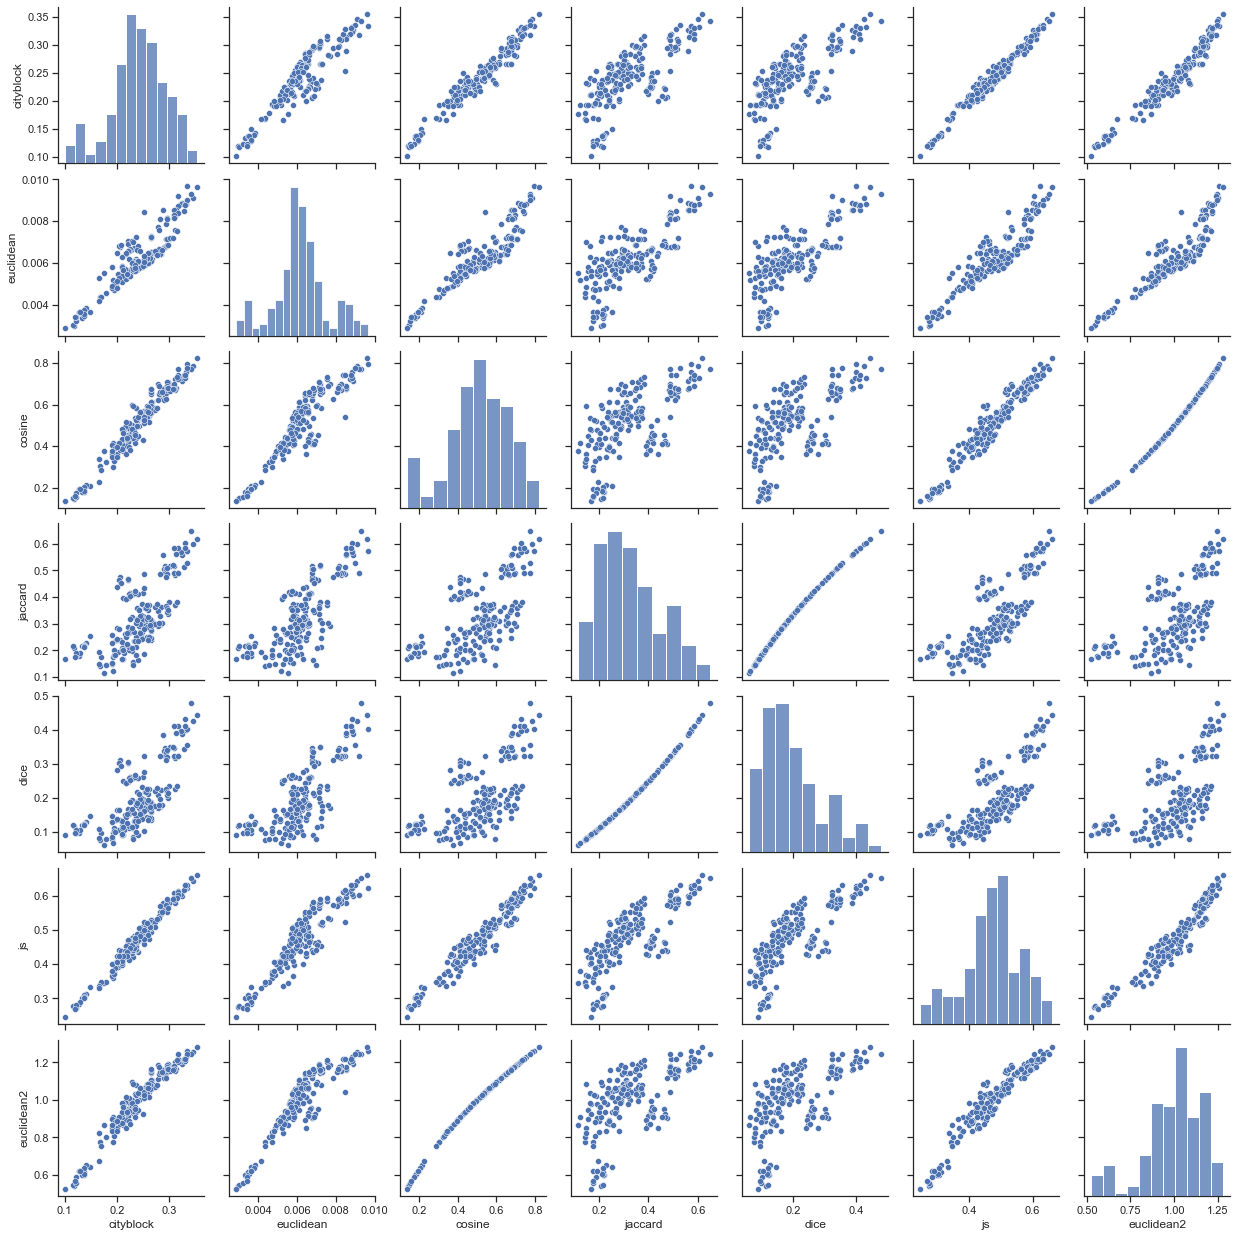

In [31]:
sns.pairplot(SAMPLE)

In [32]:
PAIRS.sort_values('cosine').head(20).style.background_gradient('YlGn', high=1)

## Create Clusters

### Hiearchical

In [33]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [34]:
def hca(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC.title.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

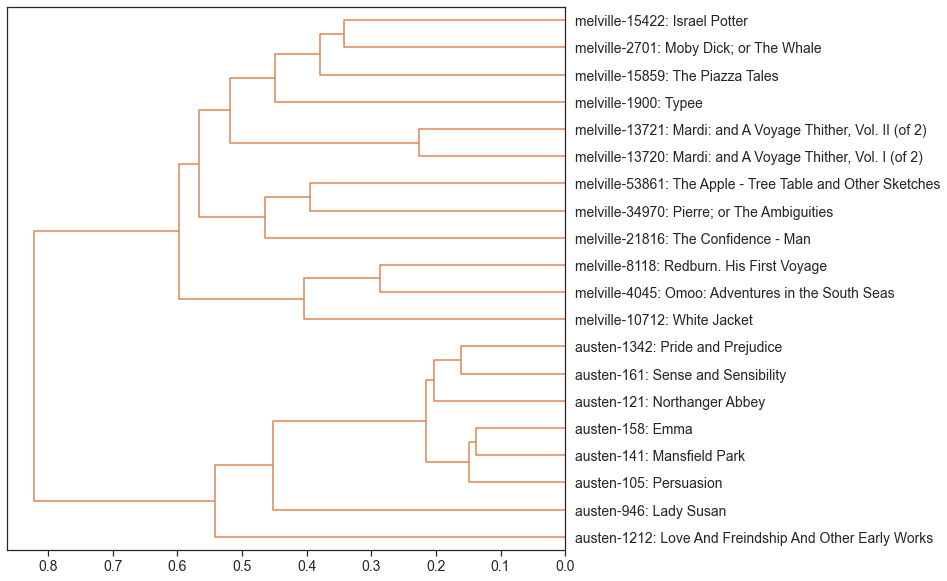

In [35]:
hca(PAIRS.cosine, color_thresh=1)

<Figure size 432x288 with 0 Axes>

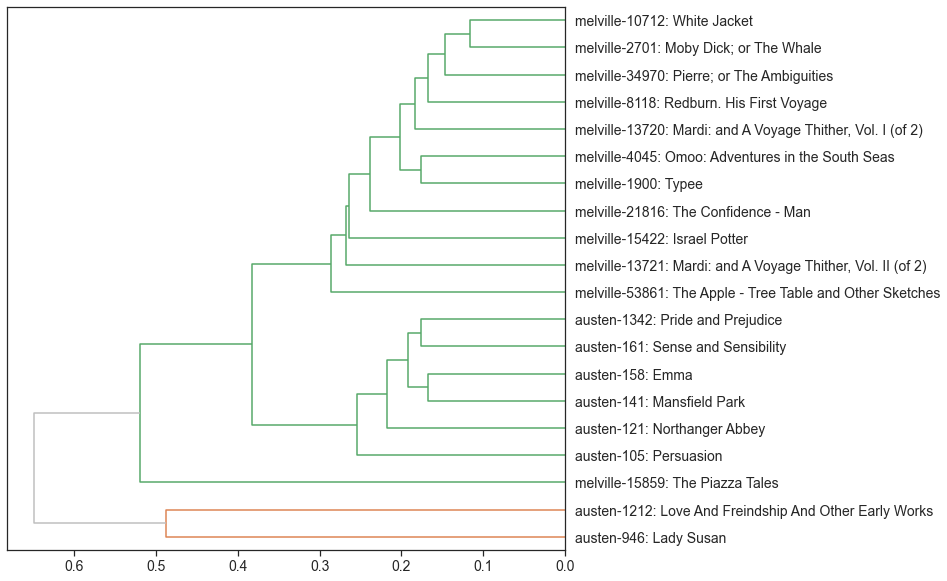

In [36]:
hca(PAIRS.jaccard, color_thresh=.6)

<Figure size 432x288 with 0 Axes>

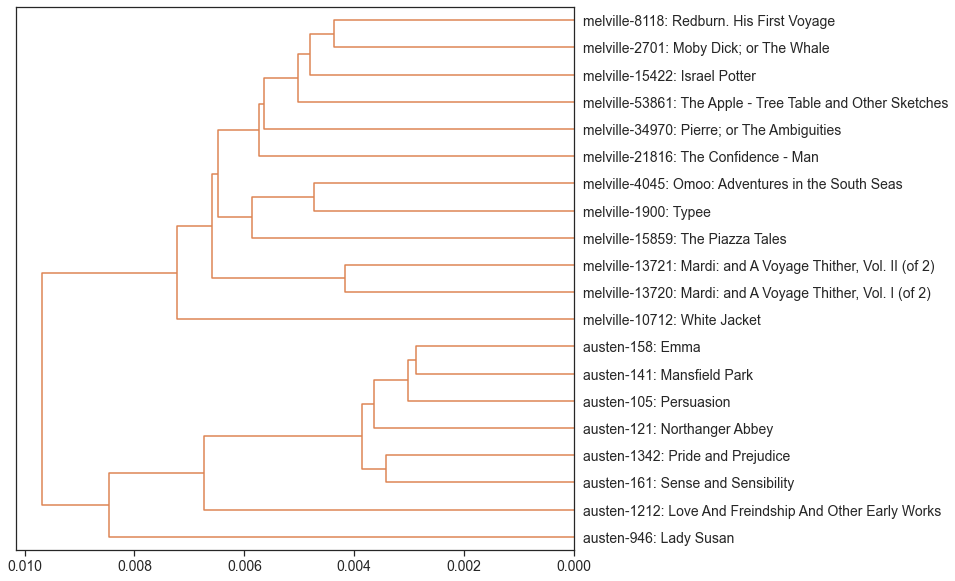

In [37]:
hca(PAIRS.euclidean, color_thresh=.3)

<Figure size 432x288 with 0 Axes>

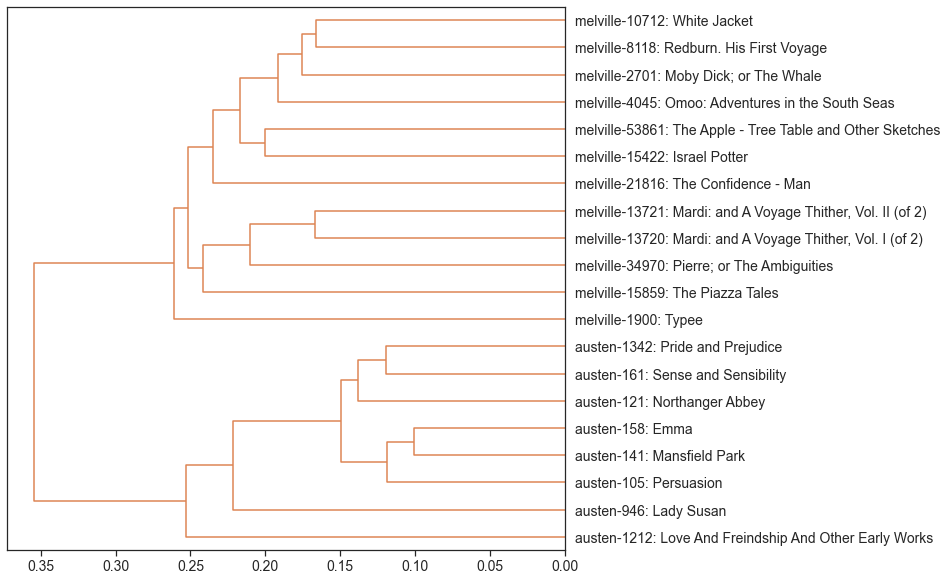

In [38]:
hca(PAIRS.cityblock, color_thresh=8)

<Figure size 432x288 with 0 Axes>

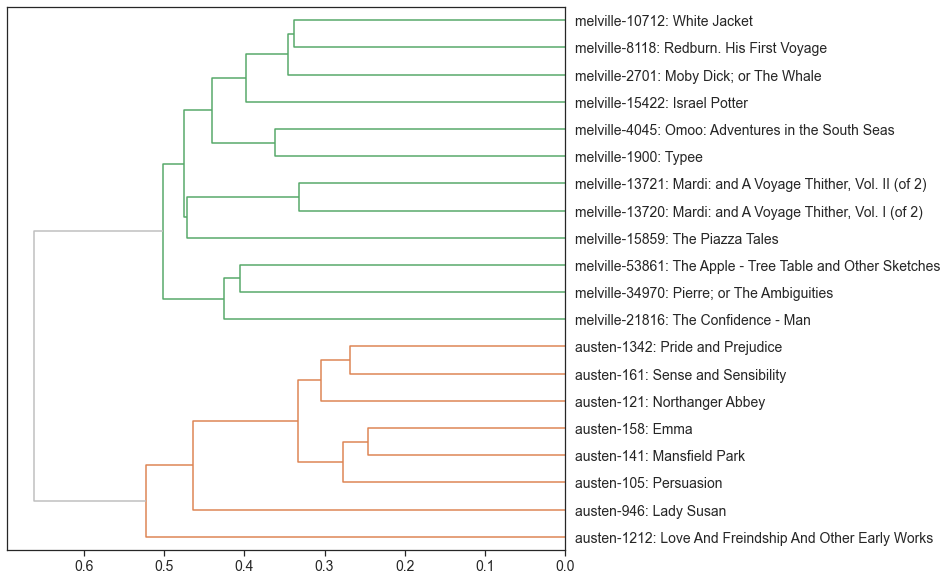

In [39]:
hca(PAIRS.js, color_thresh=.6)

### K-Means

K-Means *only* uses Euclidean distance. Why?

* The K-Means procedure does not explicitly use pairwise distances between data points. 
* Instead, it repeatedly assigns points to the closest centroid thereby using Euclidean distance from data points to a centroid. 
* However, K-Means is *implicitly* based on pairwise Euclidean distances between data points, because the sum of squared deviations from centroid is equal to the sum of pairwise squared Euclidean distances divided by the number of points. 
* The term "centroid" is itself from Euclidean geometry. It is multivariate mean in Euclidean space. Euclidean space is about euclidean distances. Non-Euclidean distances will generally not span Euclidean space. That's why K-Means is for Euclidean distances only.

See the [Cross Validated](https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric) post on this.

In [40]:
from sklearn.cluster import KMeans

In [41]:
n_clusters = 4

In [42]:
DOC['y_raw'] = KMeans(n_clusters).fit_predict(TFIDF)
DOC['y_L0'] = KMeans(n_clusters).fit_predict(L0)
DOC['y_L1'] = KMeans(n_clusters).fit_predict(L1)
DOC['y_L2'] = KMeans(n_clusters).fit_predict(L2)

In [43]:
DOC.sort_values('y_raw').style.background_gradient(cmap='YlGn', high=1)

,book_id,title,y_raw,y_L0,y_L1,y_L2
doc_id,,,,,,
5,946,austen-946: Lady Susan,0,3,3,0
0,105,austen-105: Persuasion,1,0,1,2
1,121,austen-121: Northanger Abbey,1,0,1,2
2,141,austen-141: Mansfield Park,1,0,1,2
3,158,austen-158: Emma,1,0,1,2
4,161,austen-161: Sense and Sensibility,1,0,1,2
7,1342,austen-1342: Pride and Prejudice,1,0,1,2
17,21816,melville-21816: The Confidence - Man,2,1,0,3
16,15859,melville-15859: The Piazza Tales,2,2,0,1


## Save Work

In [44]:
# DOC.to_csv('{}/{}-DOC3.csv'.format(data_out, data_prefix))
LIB.to_csv('{}/{}-LIB2.csv'.format(data_out, data_prefix))
TFIDF.to_csv('{}/{}-TFIDF_book.csv'.format(data_out, data_prefix))

## Experimental

Here we write out own agglomerative clustering algorithm. It builds a graph from the TFIDF table (which is effectively the DOC table) and the PAIRS table of distances between all pairs of docs.

In [50]:
def get_hac_graph(dist_measure = 'cityblock'):

    global TFIDF, PAIRS

    D = TFIDF.reset_index(drop=True).copy()
    P = PAIRS[[dist_measure]].copy()

    # This represents the parent-child egdges between documents and clusters
    # and between clusters and clusters. It will grow with the algorithm.
    EDGES = pd.DataFrame(index=D.index)
    EDGES['c'] = None
    
    
    # This represnets the nodes, starting with the documents. It will be 
    # be augmented by clusters which will behave as documents, having vectors
    # of term weights based on averages of its children.
    NODES = pd.DataFrame(index=D.index)
    NODES['type'] = 'doc'
    NODES['label'] = LIB.loc[TFIDF.index].reset_index().title
    NODES['source'] = LIB.loc[TFIDF.index].reset_index().author

    L = len(P) # The initial length of the PAIRS table
    N = len(D) # The initial number of documents

    cid = N - 1 # To be used for newly created clusters, whose IDs

    while 1:

        # Find closest pair of documents (or clusters)
        d1, d2 = P[dist_measure].idxmin(1)

        # Assign a parent node to this pair
        cid += 1
        EDGES.loc[[d1,d2], 'c'] = cid
        EDGES.loc[[d1,d2], 'dist'] = P[dist_measure].min()
        
        # Add this node to the edges tables with no parent
        EDGES = EDGES.append(pd.DataFrame(dict(c=None), index=[cid]))

        # Update nodes
        NODES = NODES.append(pd.DataFrame({'type':'cluster', 'label':f"C{cid}", 'source':'algo'}, index=[cid]))

        # Get new doc
        d3 = pd.DataFrame([D.loc[[d1,d2]].mean()], index=[cid])

        # Update docs 
        D = D.append(d3)
        D = D.drop(d1)
        D = D.drop(d2)

        # Update pairs
        q = f'doc_a == {d1} or doc_a == {d2} or doc_b == {d1} or doc_b == {d2}'
        P = P.drop(P.query(q).index)

        # Append new pairs
        try:
            my_pairs = pd.DataFrame(index=pd.MultiIndex.from_tuples([(idx, cid) for idx in D.index if idx != cid]))
            my_pairs.index.names = ['doc_a', 'doc_b']
            my_pairs[dist_measure] = None
            P = P.append(my_pairs)
            P[dist_measure] = pdist(D, dist_measure)
        except:
            break

    EDGES = EDGES.dropna().copy()
    EDGES['z'] = (EDGES.dist - EDGES.dist.mean()) / EDGES.dist.std()
    return NODES, EDGES

In [51]:
def print_graph(NODES, EDGES, fname='test-tree'):

    global TFIDF

    N = len(TFIDF)
    
    shapes = {'doc': 'rectangle', 'cluster': 'circle'}
    colors = {'austen': 'green', 'melville': 'red', 'algo':'gray'}
    
    nodes = '\n'.join(NODES.apply(lambda x: f'{x.name} [label="{x.label}", color="{colors[x.source]}", shape="{shapes[x.type]}"]', 1).to_list())
    edges = '\n'.join(EDGES.sort_values('c').apply(lambda x: f'{x.name} -> {int(x.c)} [label="{round(x.z,4)}", len={round(x.dist * 100, 2)}]', 1).to_list())

    graph = """
    digraph G {{
    rankdir=LR
    # NODES
    {0}
    # EDGES
    {1}
    {{rank=same; {2} }}
    }}
    """.format(nodes, edges, ';'.join([str(i) for i in range(N)]))

    with open(f"{data_out}/graphs/{fname}.dot", 'w') as out:
        out.write(graph)

In [69]:
dist_measure = 'cosine'

In [70]:
NODES, EDGES = get_hac_graph(dist_measure=dist_measure)

In [71]:
print_graph(NODES, EDGES, f"test-{dist_measure}")

In [72]:
import os

graph_types = 'dot fdp'.split()
for gt in graph_types:
    cmd = f"dot -Tpng {data_out}/graphs/test-{dist_measure}.dot -K{gt} > {data_out}/graphs/test-{dist_measure}-{gt}.png; {data_out}/graphs/open test-{dist_measure}-{gt}.png"
    os.system(cmd)